In [1]:
import numpy as np
import pandas as pd
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.cross_decomposition
import sklearn.neighbors
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## SETUP
sn = 1
setnumber = 'FD00' + str(sn)

In [3]:
## READ DATA
print 'read data'
train = pd.read_csv('data/train_'+setnumber+'.csv')
train_RULs = np.array([train.loc[train.id==i, 'cycle'].max() for i in train.id.unique()])
test = pd.read_csv('data/test_'+setnumber+'.csv')
test_RULs = np.array([test.loc[test.id==i, 'RUL'].min() for i in train.id.unique()])
print train

read data
       Unnamed: 0   id  cycle  setting1  setting2  setting3      s1      s2  \
0               0    1      1   -0.0007   -0.0004     100.0  518.67  641.82   
1               1    1      2    0.0019   -0.0003     100.0  518.67  642.15   
2               2    1      3   -0.0043    0.0003     100.0  518.67  642.35   
3               3    1      4    0.0007    0.0000     100.0  518.67  642.35   
4               4    1      5   -0.0019   -0.0002     100.0  518.67  642.37   
5               5    1      6   -0.0043   -0.0001     100.0  518.67  642.10   
6               6    1      7    0.0010    0.0001     100.0  518.67  642.48   
7               7    1      8   -0.0034    0.0003     100.0  518.67  642.56   
8               8    1      9    0.0008    0.0001     100.0  518.67  642.12   
9               9    1     10   -0.0033    0.0001     100.0  518.67  641.71   
10             10    1     11    0.0018   -0.0003     100.0  518.67  642.28   
11             11    1     12    0.0016   

In [4]:
# DROP EXTRA COLUMN(S)
print 'drop index column'
drop_cols = ['Unnamed: 0', 'setting1', 'setting2', 'setting3']#, 's1', 's18', 's19']
train.drop(drop_cols, 1, inplace=True)
test.drop(drop_cols, 1, inplace=True)
print train

drop index column
        id  cycle      s1      s2       s3       s4     s5     s6      s7  \
0        1      1  518.67  641.82  1589.70  1400.60  14.62  21.61  554.36   
1        1      2  518.67  642.15  1591.82  1403.14  14.62  21.61  553.75   
2        1      3  518.67  642.35  1587.99  1404.20  14.62  21.61  554.26   
3        1      4  518.67  642.35  1582.79  1401.87  14.62  21.61  554.45   
4        1      5  518.67  642.37  1582.85  1406.22  14.62  21.61  554.00   
5        1      6  518.67  642.10  1584.47  1398.37  14.62  21.61  554.67   
6        1      7  518.67  642.48  1592.32  1397.77  14.62  21.61  554.34   
7        1      8  518.67  642.56  1582.96  1400.97  14.62  21.61  553.85   
8        1      9  518.67  642.12  1590.98  1394.80  14.62  21.61  553.69   
9        1     10  518.67  641.71  1591.24  1400.46  14.62  21.61  553.59   
10       1     11  518.67  642.28  1581.75  1400.64  14.62  21.61  554.54   
11       1     12  518.67  642.06  1583.41  1400.15  14.62

In [5]:
## SCALE DATA
scale_separate = True

train_scalables = train.loc[:,train.columns.difference(['id', 'cycle'])].values
test_scalables = test.loc[:,test.columns.difference(['id', 'cycle'])].values
if scale_separate:
    print 'normalize features (using MinMaxScaler) - train and test set are normalized separately!'

    train_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1)).fit(train_scalables)
    test_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1)).fit(test_scalables)
    train_values = train_scaler.transform(train_scalables)
    test_values = test_scaler.transform(test_scalables)
else:
    print 'normalize features (using MinMaxScaler) - '
    print 'test set is transformed using the scaler trained on the training set'
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1)).fit(train_scalables)
    train_values = scaler.transform(train_scalables)
    test_values = scaler.transform(test_scalables)
    
train.loc[:,train.columns.difference(['id', 'cycle'])] = train_values
test.loc[:,test.columns.difference(['id', 'cycle'])] = test_values


print 'bin RUL values'
bins = [0, 0.25, 0.5, 0.75, 1.0]
status_labels = ['urgent', 'short', 'medium', 'long']
train['status'] = pd.cut(train['RUL'], bins, labels=status_labels)
test['status'] = pd.cut(test['RUL'], bins, labels=status_labels)

print 'TRAINING SET\n', train.status.value_counts()
print 'TEST SET\n', test.status.value_counts()

normalize features (using MinMaxScaler) - train and test set are normalized separately!
bin RUL values
TRAINING SET
urgent    9000
short     8362
medium    2823
long       346
Name: status, dtype: int64
TEST SET
short     6193
urgent    5183
medium    1462
long       257
Name: status, dtype: int64


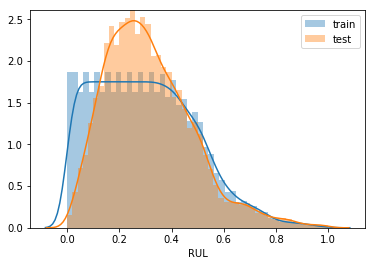

In [6]:
sns.distplot(train.RUL, label='train')
sns.distplot(test.RUL, label='test')
plt.legend()
plt.show()

In [7]:
## SEPARATE FEATURES AND LABELS
train_X = train.values[:,2:-2]
train_y = train.values[:,-2]
test_X = test.values[:,2:-2]
test_y = test.values[:,-2]


## ENCODE CLASS LABELS
def encode_labels(train_y):
    print 'encode labels as one-vs-all vectors'
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(train_y)
    train_y = le.transform(train_y)

    lb = sklearn.preprocessing.LabelBinarizer()
    lb.fit(train_y)
    train_y = lb.transform(train_y)

    return le, lb, train_y

def transform_label(y, le, lb):
    return lb.transform(le.transform(y))

def invert_transform_label(y, le, lb):
    return le.inverse_transform(lb.inverse_transform(y))

le, lb, train_y = encode_labels(train_y)
test_y = transform_label(test_y, le, lb)


[ 0.64959963  0.07836907  0.06725115  0.0292728   0.0266381   0.02417523
  0.02265165  0.02133499  0.01908868  0.01590062  0.01511655  0.01344372
  0.00893495  0.00718381  0.00103904]
[ 0.64959963  0.72796871  0.79521986  0.82449265  0.85113075  0.87530599
  0.89795764  0.91929263  0.93838131  0.95428193  0.96939849  0.98284221
  0.99177715  0.99896096  1.        ]


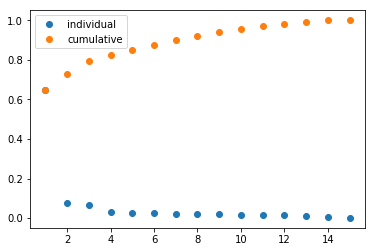

In [8]:
## COMPONENT ANALYSIS
PCA = True
CCA = False
nc = 15

if PCA:
    pca = sklearn.decomposition.PCA(n_components=nc).fit(train_X)
    trainX = pca.transform(train_X)
    testX = pca.transform(test_X)
    evals = pca.explained_variance_ratio_
    evals_cs = evals.cumsum()
    print evals
    print evals_cs
    plt.plot(range(1, nc+1), evals, 'o', label='individual')
    plt.plot(range(1, nc+1), evals_cs, 'o', label='cumulative')
    plt.legend()
    plt.show()
elif CCA:
    cca = sklearn.cross_decomposition.CCA(n_components=nc).fit(train_X, train_y)
    trainX = cca.transform(train_X)
    testX = cca.transform(test_X)
    

(13096, 16) (20631, 16)
Index([u'comp_1', u'comp_2', u'comp_3', u'comp_4', u'comp_5', u'comp_6',
       u'comp_7', u'comp_8', u'comp_9', u'comp_10', u'comp_11', u'comp_12',
       u'comp_13', u'comp_14', u'comp_15', u'status'],
      dtype='object')


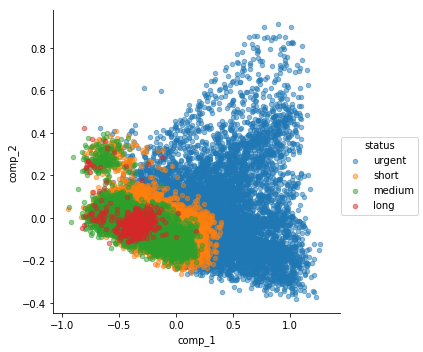

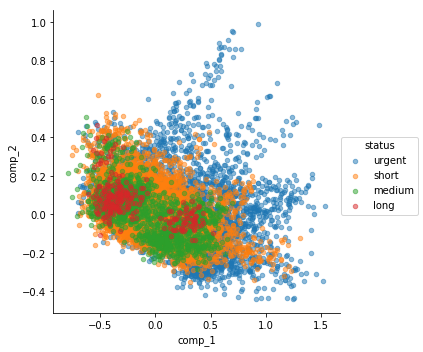

In [9]:
X_train = pd.DataFrame(trainX, columns=['comp_'+str(x) for x in range(1, trainX.shape[1]+1)])
X_train['status'] = train['status']

X_test = pd.DataFrame(testX, columns=['comp_'+str(x) for x in range(1, testX.shape[1]+1)])
X_test['status'] = test['status']

print X_test.shape, X_train.shape
print X_train.columns
sns.lmplot('comp_1', 'comp_2', hue='status', fit_reg=False, data=X_train, markers='o', scatter_kws={'alpha':0.5, 's':20})
sns.lmplot('comp_1', 'comp_2', hue='status', fit_reg=False, data=X_test, markers='o', scatter_kws={'alpha':0.5, 's':20})
plt.show()


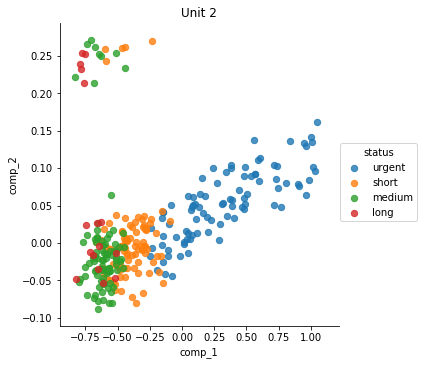

In [10]:
## PLOT TRAJECTORY OF UNIT (i)
i = 2
inds = (train.loc[train.id==i]).index
sns.lmplot('comp_1', 'comp_2', hue='status', fit_reg=False, data=X_train.iloc[inds], markers='o', scatter_kws={'alpha':0.8, 's':40})
plt.title('Unit %d'%i)
plt.show()